<a href="https://colab.research.google.com/github/KK-Gayatri-P/Membership-Inference-Attacks/blob/main/Membership_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Membership Inference Attack**

The past few years have shown the increase in popularity of the different deep learning and machine learning algorithms in different firlds, from healthcare to automation industry and in security as well.But with this rise , there has been a growth in the susceptibility of these algortihms being used, automatically making the data set susceptible as well.




**What is Membership Inference**

One such attack is black-box Membership Inference attack. A black box scenario is one in which the attacker can give input to the model and recieve the corresponding output of the data (like any other client wanting to use the model).Despite these limitations, a carefully constructed adversary is able to infer the membership of a data record in the training dataset.

Without the original membership data it seems impossible to train an adversary to infer membership. This problem necessitates an additional shadow model which mimics the behavior of the target model and whose training dataset membership is known. The outputs of the shadow model along with the membership labels are then used to train the attack model.



This is the basic scenario:-

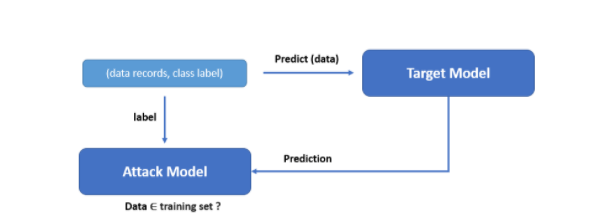

How Membership Inference and Model Inversion are different -

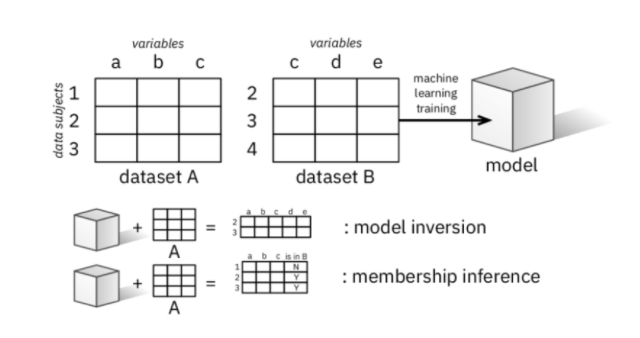

**The Models**

**Target Model:**

Purpose- Perform a classification task

Inputs- Samples from a multi-class data distribution(images, incase of an image classifier).

Outputs- Categorical Class labels (probability vector with length equal to the number of classes)


**Shadow Model:**

Purpose- Produce 2 sets of classification probability vectors (one set generated from training data, another set generated from non-training data) to be used in training the attack network

Inputs- Samples from a multi-class data distribution(images, incase of an image classifier).

Outputs-Categorical Class labels (probability vector with length equal to the number of classes)

**Attack Model:**

Purpose: Perform membership inference by learning to classify probability vectors coming from the in-training set versus the out-of-training set.

Inputs: Probability vectors generated from either the in-training set or out-of-training set.

Outputs: Probability the input is a member of the in-training set.


The attackers' data set needs to be closest to the training data of the target data.

For more information, visit [this](https://github.com/csong27/membership-inference).

In [ ]:
from collections import namedtuple

import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import EMNIST, MNIST
from tqdm.notebook import tqdm, trange
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [ ]:
%matplotlib inline

Start by creating a basic classifier in PyTorch, split into two parts to signify the data owner and the computational server of a SplitNN (both parts are on the same machine in this example, but you can use your imagination).

Define hyperparameters for training the target model

In [ ]:
hyperparams = namedtuple('hyperparams', 'batch_size,epochs,learning_rate,n_data')

# Target model hyperparameters
target_hyperparams = hyperparams(
    batch_size=256,
    epochs=10,
    learning_rate=1e-4,
    n_data=20_000,  # We don't need all the training data to get a decent MNIST classifier
)


Using some part of the MNIST dataset as the training dataset and some as test data for the Target Model 

In [ ]:
mnist_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),]
)

# Target model training data
train_data = MNIST("mnist", train=True, download=True, transform=mnist_transform)

# We don't need to use all the training data for MNIST as it's a simple dataset
train_data.data = train_data.data[:target_hyperparams.n_data]
train_data.targets = train_data.targets[:target_hyperparams.n_data]

# Target model test data
test_data = MNIST("mnist", train=False, download=True, transform=mnist_transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=target_hyperparams.batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1_000)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


 **Create a basic classifier**

The classifier is split into two parts to signinfy the data owner and computational server of a server of a SplitNN.

In [ ]:
class Classifier(torch.nn.Module):
    def __init__(self, first_network, second_network) -> None:
        super().__init__()

        # --- First stage --- #
        self.stage1 = first_network
        
        # --- Second stage --- #
        # In practice, at this point the output of the previous stage would be transmitted to
        # a central server, where inference would continue
        self.stage2 = second_network

    def mobile_stage(self, x):
        return self.stage1(x)

    def forward(self, x):
        out = self.mobile_stage(x)
        out = out.view(out.size(0), -1)

        return self.stage2(out)

In [ ]:
# The first part of the network. This would be hosted on a mobile device
first_network = torch.nn.Sequential(
                torch.nn.Conv2d(1, 32, kernel_size=5, padding=0, stride=1),  # first Conv layer
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
                torch.nn.Conv2d(32, 32, kernel_size=5, padding=0, stride=1),  # second Conv layer
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
        )


# The second and final part of the network. This would be typically hosted on a central server in practice
second_network = torch.nn.Sequential(
                torch.nn.Linear(512, 256),
                torch.nn.ReLU(),
                torch.nn.Linear(256, 10),  # 10-class output
                torch.nn.Softmax(dim=-1),
        )

target_model = Classifier(first_network, second_network)
target_model

"""
Training the Target MOdel
"""

optim = torch.optim.Adam(target_model.parameters(), lr=target_hyperparams.learning_rate)
loss_criterion = torch.nn.CrossEntropyLoss()
for epoch in trange(target_hyperparams.epochs):
    train_correct = 0
    train_loss = 0.

    # Training loop
    for data, targets in train_loader:
        #print(targets)
        optim.zero_grad()
        #print(targets.size())

        output = target_model(data)

        # Update network
        loss = loss_criterion(output, targets)
        loss.backward()
        optim.step()

        # Track training statistics
        _, predicted = output.max(1)
        train_correct += predicted.eq(targets).sum().item()
        train_loss += loss.item()


# **Training a shadow model**

We don’t know exactly what data the target model has been trained on, but we do know that it’s some sort of handwritten images. Therefore we can use part of the EMNIST dataset of handwritten letters to train our attacker which can be a shadow of the Target model which is trained by the attacker.

In [ ]:
"""
Training data for Shadow model

"""

# shadow model hyperparameters
shadow_hyperparams = hyperparams(
    batch_size=32,
    epochs=10,
    learning_rate=1e-4,
    n_data=1_000,
)

emnist_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),]
)
shadow_train = EMNIST("emnist", "digits", download=True, train=True, transform=emnist_transform)

# Use the last n_data images in the test set to train the attacker
shadow_train.data = shadow_train.data[:shadow_hyperparams.n_data]
shadow_train.targets = shadow_train.targets[:shadow_hyperparams.n_data]

shadow_train_loader = torch.utils.data.DataLoader(shadow_train, batch_size=shadow_hyperparams.batch_size)

#for test data

shadow_test = EMNIST("emnist", "letters", download=True, train=False, transform=emnist_transform)

shadow_test.data = shadow_test.data[:shadow_hyperparams.n_data]
shadow_test.targets = shadow_test.targets[:shadow_hyperparams.n_data]

shadow_test_loader = torch.utils.data.DataLoader(shadow_test, batch_size=1_000)


"""
Model for Shadow Models

"""
class ShadowModel(torch.nn.Module):
    def __init__(self,first_network, second_network) -> None:
        super().__init__()

        self.stage1 = first_network
        
        # --- Second stage --- #
        # In practice, at this point the output of the previous stage would be transmitted to
        # a central server, where inference would continue
        self.stage2 = second_network
        

        
    def mobile_stage(self, x):
        return self.stage1(x)

    def forward(self, x):
        out = self.mobile_stage(x)
        out = out.view(out.size(0), -1)
        return self.stage2(out)
first_network = torch.nn.Sequential(
                torch.nn.Conv2d(1, 32, kernel_size=5, padding=0, stride=1),  # first Conv layer
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
                torch.nn.Conv2d(32, 32, kernel_size=5, padding=0, stride=1),  # second Conv layer
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
        )


# The second and final part of the network. This would be typically hosted on a central server in practice
second_network = torch.nn.Sequential(
                torch.nn.Linear(512, 256),
                torch.nn.ReLU(),
                torch.nn.Linear(256, 10),  # 10-class output
                torch.nn.Softmax(dim=-1),
        )

# Get Shadow model
shadow_model = ShadowModel(first_network,second_network)
shadow_model


ShadowModel(
  (stage1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
    (3): Softmax(dim=-1)
  )
)

Training the Shadow Model

In [ ]:
shadow_optim = torch.optim.Adam(shadow_model.parameters(), lr=shadow_hyperparams.learning_rate)
loss_criterion = torch.nn.CrossEntropyLoss()

for epoch in trange(shadow_hyperparams.epochs):
    train_correct = 0
    train_loss = 0.

    # Training loop
    for data, targets in shadow_train_loader:
        shadow_optim.zero_grad()
        output = shadow_model(data)

    # Update network
        loss = loss_criterion(output, targets)
        loss.backward()
        shadow_optim.step()

        # Track training statistics
        _, predicted = output.max(1)
        train_correct += predicted.eq(targets).sum().item()
        train_loss += loss.item()

s1=output



# **Attack Model**

**Collecting shadow model's training data and other data (not in the training dataset) for the Attack Model**

In [ ]:
training_data=shadow_train.data  #shadow model's training data

"""
For the data not present training dataset

"""
new_train = EMNIST("emnist", "digits", download=True, train=True, transform=emnist_transform)

new_hyperparams = hyperparams(
    batch_size=32,
    epochs=10,
    learning_rate=1e-4,
    n_data=10000,
)

new_train.data = new_train.data[0:1_000]
new_train.targets = shadow_train.targets[0:1_000]

new_train_loader = torch.utils.data.DataLoader(new_train, batch_size=new_hyperparams.batch_size)

not_training_data=new_train.data   #data out in training data of shadow model

print(len(shadow_train.data))

1000


Dataset for training the Attack Model

In [ ]:
#Labels for the datsets
Y2 = torch.ones([1000,1])
Y1 = torch.zeros([1000,1])
print(not_training_data.size())
#Combining into a single dataset
X=torch.cat([training_data,not_training_data])
print(X.size())
Y = torch.cat([Y1, Y2], dim=0)
print(Y.size())   

#Converting the ByteTensor into FloatTensor

X=X.type(torch.FloatTensor)
Y=Y.type(torch.FloatTensor)


#Changing the Dimentions for Classification Model
a = torch.zeros(2000, 784)
for i in range(2000):
  a[i]=X[i].reshape(784)
print((a.size()))
X=a   #Converting size of input of attack model 

torch.Size([1000, 28, 28])
torch.Size([2000, 28, 28])
torch.Size([2000, 1])
torch.Size([2000, 784])


Training the Attack Model

In [ ]:
"""
Defining the attack model
"""
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784,25)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(25, 50)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(50,1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
    
net = Net()
opt = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

"""
Training the attack model
"""
def train_epoch(model, opt, criterion, batch_size=10):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0), batch_size):

        x_batch = X[beg_i:beg_i + batch_size, :]
        y_batch = Y[beg_i:beg_i + batch_size, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = model(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    return losses


Data for Testing if a data point is present in the training dataset.

In [ ]:
sample_train = EMNIST("emnist", "digits", download=True, train=True, transform=emnist_transform)

sample_hyperparams = hyperparams(
    batch_size=16,
    epochs=10,
    learning_rate=1e-4,
    n_data=1,
)

sample_train.data = sample_train.data[3000:3008]
sample_train.targets = sample_train.targets[3000:3008]

sample_train_loader = torch.utils.data.DataLoader(sample_train, batch_size=sample_hyperparams.batch_size)

sample_data=sample_train.data
len(sample_data)

8

In [ ]:
a = torch.zeros(len(sample_data), 784)
print(sample_train.targets)
for i in range(len(sample_data)):
  a[i]=sample_data[i].reshape(784)


"""
Chaecking if the data points are present in the training dataset or not
"""
a=a.type(torch.FloatTensor)


for i in range(len(a)):
  x_t =Variable(a[i])
  #print((d[i]))
  net.eval()
  print(net(x_t))


tensor([2, 1, 0, 1, 5, 1, 7, 8])
tensor([0.9930], grad_fn=<SigmoidBackward>)
tensor([0.0001], grad_fn=<SigmoidBackward>)
tensor([0.9999], grad_fn=<SigmoidBackward>)
tensor([0.0059], grad_fn=<SigmoidBackward>)
tensor([1.0000], grad_fn=<SigmoidBackward>)
tensor([0.5528], grad_fn=<SigmoidBackward>)
tensor([0.9770], grad_fn=<SigmoidBackward>)
tensor([0.9999], grad_fn=<SigmoidBackward>)


These values are the probability for each data point to be present in the training data.

This way, one can determine if a particular dataset was in the training data set(sometimes, private) and voilate the privacy of the owner.



# **Assumptions**


**Assumption 1:** A classification model is build using a machine learning algorithm, which outputs prediction vector of probabilities for any input data record.The class with highest probability is assigned to the data record.

**Assumption 2:** The attacker can obtain the output of the target model on any
input record using a black-box query access. The range and format of the input
and output of the model is known to the attacker.

**Assumption 3:** The attacker in some cases may also know the type and architecture of the training algorithm and the model.

**Assumption 4:** The knowledge of the data universe from which the training
data of the target model is derived may be available to the attacker in some
cases.


# **References-**

https://github.com/csong27/membership-inference

https://gab41.lab41.org/membership-inference-attacks-on-neural-networks-c9dee3db67da

https://ieeexplore.ieee.org/document/7958568

http://home.iitk.ac.in/~anmolp/Review_MIA_paper
